In [12]:
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from scipy import stats


In [13]:


def load_df(csv_path='./data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #p=0.1
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'}, nrows=nrows, )# Important!!
                      #skiprows=lambda i: i > 0 and random.random() > p)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train_df = load_df()
print("loaded")


Loaded train.csv. Shape: (903653, 55)
loaded


In [14]:
#pd.set_option('display.max_columns', None)

train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
train_df['shops or not'] = train_df['totals.transactionRevenue'].values > 0

print(pd.value_counts(train_df['shops or not']))

def date_format(df):
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day

date_format(train_df)

excluded_features =['socialEngagementType','totals.visits','totals.newVisits','device.browserVersion','device.flashVersion',

         'device.language','device.browserSize','device.mobileDeviceInfo','device.mobileDeviceMarketingName',

         'device.mobileDeviceModel','device.mobileInputSelector','device.operatingSystemVersion',

         'device.screenColors','device.screenResolution','device.mobileDeviceBranding','geoNetwork.cityId',

          'geoNetwork.latitude','geoNetwork.longitude','geoNetwork.networkLocation',

          'trafficSource.adwordsClickInfo.criteriaParameters',

                    # 'trafficSource.campaignCode',

            'trafficSource.campaign','trafficSource.adContent','trafficSource.adwordsClickInfo.adNetworkType',

            'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.isVideoAd',

            'trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot']

A=train_df.drop(excluded_features,axis=1)

print(A.shape)

replace_null_values={'trafficSource.isTrueDirect': 'False', 'trafficSource.keyword': 'unknown',

                     'trafficSource.referralPath': 'unknown'}

B=A.fillna(value=replace_null_values)


categorical_features = [

    _f for _f in B.columns

    if (B[_f].dtype == 'object')

]



#print(categorical_features)



for f in categorical_features:

    B[f], indexer = pd.factorize(B[f])



M=B.drop(['shops or not','date','vis_date','totals.transactionRevenue'],axis=1)

y=B['shops or not']

# y=train_df['shops or not']



#28 columns

print(M.shape)

False    892138
True      11515
Name: shops or not, dtype: int64
(903653, 33)
(903653, 29)


                       feature  importance
18                 totals.hits    0.226341
19            totals.pageviews    0.176751
17              totals.bounces    0.070119
11        geoNetwork.continent    0.046093
5               visitStartTime    0.036001
27             sess_date_hours    0.035738
3                      visitId    0.035118
1                fullVisitorId    0.034333
2                    sessionId    0.033153
28               sess_date_dom    0.030222
4                  visitNumber    0.026275
26               sess_date_dow    0.026088
21  trafficSource.isTrueDirect    0.025972
14    geoNetwork.networkDomain    0.023808
0              channelGrouping    0.020838
10             geoNetwork.city    0.019889
9       device.operatingSystem    0.019556
13            geoNetwork.metro    0.018572
15           geoNetwork.region    0.018270
16     geoNetwork.subContinent    0.017636
8              device.isMobile    0.010938
12          geoNetwork.country    0.010464
6          

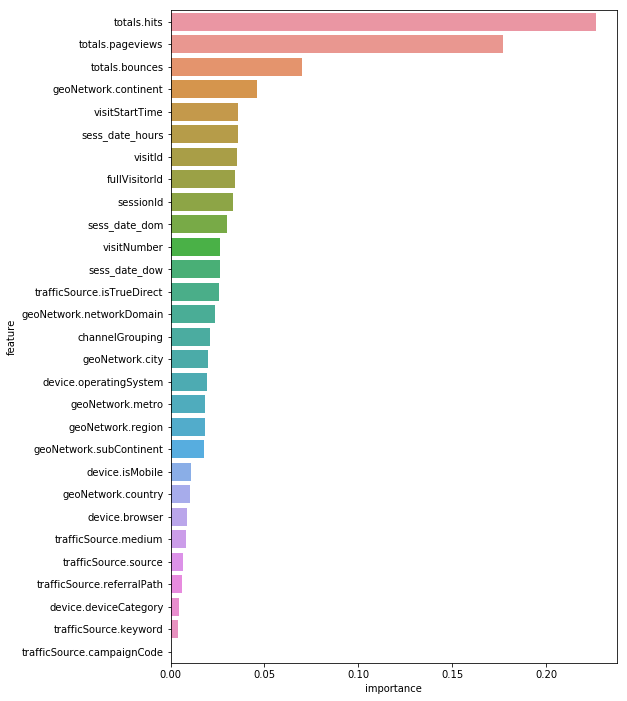

In [15]:
# feature selection
from sklearn.ensemble import ExtraTreesClassifier
# here criterion='entropy'  for the information gain, 'gini' for the Gini impurity 
model = ExtraTreesClassifier(criterion='entropy')
model.fit(M,y)

imp_df = pd.DataFrame()
imp_df['feature'] = M.columns
imp_df['importance'] = model.feature_importances_

print(imp_df.sort_values('importance', ascending=False))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
sns.barplot(x='importance', y='feature', data=imp_df.sort_values('importance', ascending=False))

imp_df = imp_df[imp_df['importance'].astype('float') < 0.0005] 

dropFeatures = imp_df['feature'].values 
print(dropFeatures)

M=M.drop(dropFeatures,axis=1)

In [17]:
from sklearn.model_selection import KFold, GroupKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report


folds = GroupKFold(n_splits=5)
oof_clf_preds = np.zeros(M.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(M, y, groups=M['fullVisitorId'])):
    trn_x, trn_y = M.iloc[trn_], y.iloc[trn_]
    val_x, val_y = M.iloc[val_], y.iloc[val_]

    #using smote     
    sm = SMOTE(random_state=2)
    trn_xSampled,trn_ySampled = sm.fit_sample(trn_x, trn_y)
 
    #using class weight for imbalanced data
    #DecTreeModel = DecisionTreeClassifier(class_weight={0:1,1:7})
    DecTreeModel = DecisionTreeClassifier()
    DecTreeModel.fit(trn_xSampled,trn_ySampled)
    oof_clf_preds[val_] = DecTreeModel.predict_proba(val_x)[:,1]

#print(classification_report(y, oof_clf_preds))    
def eval_metric(prediction, truth):
    print("recall:       {}".format(recall_score(prediction, truth)))
    print("precision:    {}".format(precision_score(prediction, truth)))
    print("f1_score:     {}".format(f1_score(prediction, truth)))
    print("\nconfusion_matrix:\n",confusion_matrix(prediction, truth))

eval_metric(oof_clf_preds,y)    
print("prob")
print(M.shape)
print(oof_clf_preds.shape)


recall:       0.3051377513030529
precision:    0.3558836300477638
f1_score:     0.3285628382441371

confusion_matrix:
 [[882806   7417]
 [  9332   4098]]
prob
(903653, 28)
(903653,)


In [18]:
M['non_zero_proba'] = oof_clf_preds

print(M.shape)
from sklearn.tree import DecisionTreeRegressor

oof_reg_preds = np.zeros(M.shape[0])

y1 = train_df["totals.transactionRevenue"].fillna(0)

for fold_, (trn_, val_) in enumerate(folds.split(M, y1, groups=M['fullVisitorId'])):
    trn_x, trn_y = M.iloc[trn_], y1.iloc[trn_]
    val_x, val_y = M.iloc[val_], y1.iloc[val_]
    
   
    DecTreeReg = DecisionTreeRegressor()
    DecTreeReg.fit(trn_x,trn_y)
    oof_reg_preds[val_] = DecTreeReg.predict(val_x)


print(stats.describe(y1))    
print(stats.describe(oof_reg_preds))


from sklearn.metrics import mean_squared_error    
mean_squared_error(np.log1p(y1), np.log1p(oof_reg_preds)) ** .5 


(903653, 29)
DescribeResult(nobs=903653, minmax=(0.0, 23129500000.0), mean=1704272.8126836296, variance=2785586878006657.0, skewness=207.8943218561069, kurtosis=69866.38533551784)
DescribeResult(nobs=903653, minmax=(0.0, 10589140000.0), mean=2116946.8922252236, variance=2200733324421268.8, skewness=83.52708839807791, kurtosis=12018.64138415899)


2.449490708373825